# **Tarea 15**
## Análisis de datos
### **Ana Isabel Moreno Hernández**

------------------------------------

Importamos librerías necesarias:

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Descargamos los datos: 

In [2]:
file = pd.read_csv('result.txt')

__________________________________________________

**Función para generar números aleatorios con distribución uniforme(randoms)**

In [3]:
def transform(dec, ra):
    dec = dec*math.pi/180
    ra = ra*math.pi/180
    x = np.sin(dec)*np.cos(ra) # Transforma a coordenadas cartesianas
    y = np.sin(ra)*np.sin(dec)
    z = np.cos(dec)
    return x, y, z


def Random(dec, ra, nr):
    x, y, z = transform(dec, ra)
    return np.random.uniform(min(x),max(x),nr), np.random.uniform(min(y),max(y),nr), np.random.uniform(min(z),max(z),nr)
# Regresa tres vectores con coordenadas para puntos aleatorios uniformemente distribuidos. 

Graficamos nuestra distribución de datos utilizados:

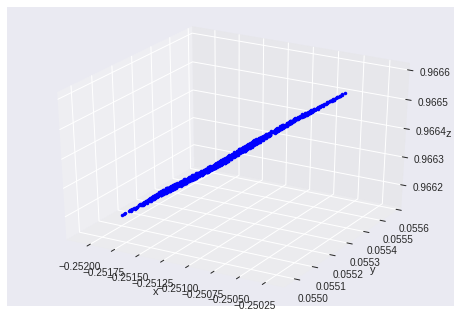

In [4]:
x, y, z = transform(file['dec'][0:1000], file['ra'][0:1000])

from mpl_toolkits import mplot3d

plt.style.use('seaborn') # Estilo

ax = plt.axes(projection='3d')
ax.plot3D(x, y, z, '.b');
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z');

Probamos la función Random:

In [5]:
xrand, yrand, zrand = Random(file['dec'][0:1000],file['ra'][0:1000], 1000) # Seleccionamos 1000 datos y generamos 1000 coordenadas.

Graficamos para observar si están uniformemente distribuidos:

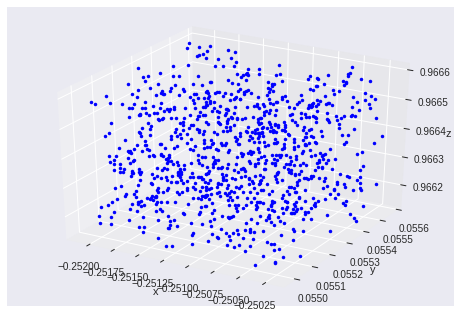

In [6]:
plt.style.use('seaborn') # Estilo

ax = plt.axes(projection='3d')
ax.plot3D(xrand, yrand, zrand, '.b');
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z');

-----------------------

**Funciones para obtener los histogramas.**

Anteriormente guardamos las distancias en arreglos, lo cual no era muy conveniente. Tratamos de resolver el problema llenando el histograma dentro del ciclo. 

Para llenar un histograma dentro de un ciclo, utilizamos physt.

In [138]:
# Librerías necesarias
import physt
from physt import h1, h2, histogramdd

%matplotlib inline

Checamos si funciona:

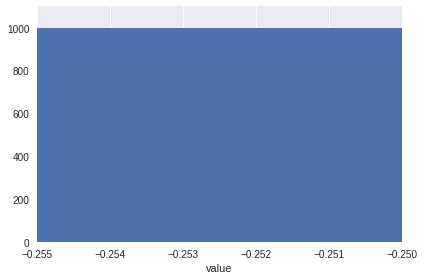

In [14]:
# Creamos un histograma vacío.
h = h1(None, "fixed_width", bin_width=0.005, name="Prueba", axis_name="value", adaptive=True)

for i in range(len(xrand)):
    h.fill(xrand[i])

h.plot()

Y sí es uniforme, tal y como lo esperábamos. 

Ahora probamos| una de nuestras funciones para saber si funciona este llenado.

In [35]:
def distance(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

# Esto es para DD
def dede(p, datos, bin_width):
    h = h1(None, "fixed_width", bin_width=bin_width, name="dd", axis_name="value", adaptive=True) # Empty histogram
    for i in range(datos):
        for j in range(i+1, datos):
            h.fill(distance(p[i],p[j]))
    return h

In [36]:
dede(np.array([xrand,yrand,zrand]).T, len(xrand), 0.0003)

Histogram1D('dd', bins=(7,), total=499500, dtype=int64)

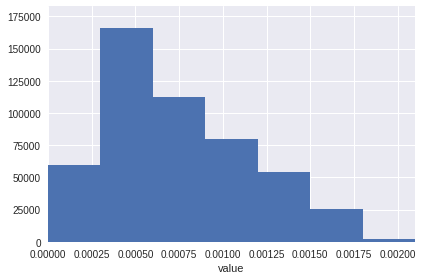

In [37]:
h.plot()

In [39]:
h.frequencies

array([ 59299, 166076, 112658,  79986,  53806,  25233,   2442])

------------------------------------------

**Funciones para calcular la correlación.**

In [53]:
def distance(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

# Esto es para DD
def dede(p, datos, bin_width):
    h = h1(None, "fixed_width", bin_width=bin_width, name="dd", axis_name="value", adaptive=True) # Empty histogram
    for i in range(datos):
        for j in range(i+1, datos):
            h.fill(distance(p[i],p[j]))
    return h

# Esto es para DR
def der(p, p_rand, datos, datos_rand, bin_width):
    h = h1(None, "fixed_width", bin_width=bin_width, name="dd", axis_name="value", adaptive=True) # Empty histogram
    for i in range(datos):
        for j in range(datos_rand):         
            h.fill(distance(p[i],p_rand[j]))
    return h

# Esto es para RR, que es la misma función para DD, pero la incluímos para obtener la correlación.
def rere(p_rand, datos_rand, bin_width):
    h = h1(None, "fixed_width", bin_width=bin_width, name="dd", axis_name="value", adaptive=True) # Empty histogram
    for i in range(datos_rand):
        for j in range(i+1, datos_rand):         
            h.fill(distance(p_rand[i],p_rand[j]))
    return h

#función de correlación
def correlation(p,p_rand, datos, datos_rand, bin_width):
    dd_h = dede(p, datos, bin_width)
    dr_h = der(p, p_rand, datos, datos_rand, bin_width)
    rr_h = rere(p_rand, datos_rand, bin_width)
    return dd_h, dr_h, rr_h

Aunque la función *correlation* nos ayuda a generar los histogramas, es útil definir una función que los grafique en conjunto. 

In [73]:
def plot(p, p_rand, datos, datos_rand, bin_width):
    dd, dr, rr = correlation(p, p_rand, datos, datos_rand, bin_width) # Llamamos a correlation
    axis = dd.plot(label="DD", color="green", alpha=0.3)
    dr.plot(label="DR", color="red", alpha=0.3, ax=axis) # Unimos las gráficas para que estén en el mismo canvas
    rr.plot(label="RR", color="blue", alpha=0.3, ax=axis)
    axis.legend()
    return dd.plot, dr.plot, rr.plot # Graficamos todo

Finalmente, definimos las funciones que calculan la correlación. Definiremos tres diferentes:

In [130]:
def simple_corr(p, p_rand, datos, datos_rand, bin_width):
    dd, dr, rr = correlation(p, p_rand, datos, datos_rand, bin_width) # Llamamos a correlation
    dd_c = dd.frequencies
    rr_c = rr.frequencies
    dr_c = dr.frequencies
    print(dd_c, rr_c, dr_c)
    nd = datos*(datos-1)/2
    nr = datos_rand*(datos_rand-1)/2
    ndr = datos*datos_rand
    return (dd_c/rr_c) -1, ((dd_c)-2*(dr_c)+(rr_c))/(rr_c), ((dd_c/nd)-2*(dr_c/ndr)+(rr_c/nr))/(rr_c/nr) 

----------------------------

**Pruebas**

Para saber si este programa funciona, generamos dos muestras de números aleatorios distribuidos uniformemente. 

In [87]:
xrand1, yrand1, zrand1 = Random(file['dec'][0:1000],file['ra'][0:1000], 1000) # Seleccionamos 1000 datos y generamos 1000 coordenadas.

In [88]:
xrand2, yrand2, zrand2 = Random(file['dec'][0:1000],file['ra'][0:1000], 1000) # Seleccionamos 1000 datos y generamos 1000 coordenadas.

Verificamos que las muestras son diferentes.

In [89]:
xrand1 == xrand2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Ploteamos los histogramas utilizando la función definida 'plot'

(<physt.plotting.PlottingProxy at 0x7fee5ae39590>,
 <physt.plotting.PlottingProxy at 0x7fee5aeeb0d0>)

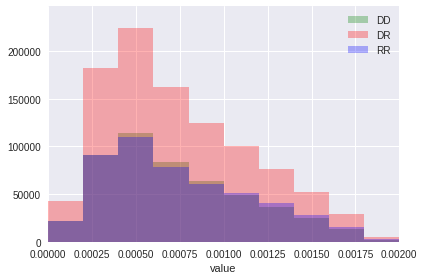

In [90]:
plot(np.array([xrand1, yrand1, zrand1]).T, np.array([xrand2, yrand2, zrand2]).T, len(xrand1), len(xrand2), 0.0002)

Calculamos la correlación:

In [95]:
results = simple_corr(np.array([xrand1, yrand1, zrand1]).T, np.array([xrand2, yrand2, zrand2]).T, len(xrand1), len(xrand2), 0.0002)

In [96]:
results

(array([-0.01299422, -0.00558103,  0.03695978,  0.06894711,  0.0556558 ,
        -0.02573406, -0.10481706, -0.11975384, -0.14241245, -0.35683912]),
 array([-2.00069364, -1.99717666, -2.03324112, -2.06894711, -2.07326965,
        -1.97899864, -1.904827  , -1.87688289, -1.86770428, -1.68143161]),
 array([-0.00485008,  0.00061696,  0.00389443,  0.00206895, -0.00674246,
        -0.00038972, -0.00292203,  0.0035602 , -0.00319572, -0.01747307]))

En estos tres arreglos se muestran las tres diferentes formas de calcular la correlación. results[0] es (dd_c/rr_c) -1, results[1] ((dd_c)-2*(dr_c)+(rr_c))/(rr_c) y results[3] ((dd_c/nd)-2*(dr_c/ndr)+(rr_c/nr))/(rr_c/nr),  

Notamos que results[0] y results[3] son los más cercanos a cero. 

---------------------------

Ahora probamos nuestro código con los datos originales. 

**Correlación**

Seleccionamos 1000 datos de nuestra muestra:

In [143]:
ra = file['ra'][0:1000]
dec = file['dec'][0:1000]

In [144]:
xrand1, yrand1, zrand1 = Random(ra,dec,1000) # Seleccionamos 1000 datos y generamos 1000 coordenadas.

In [145]:
x, y, z = transform(ra,dec)

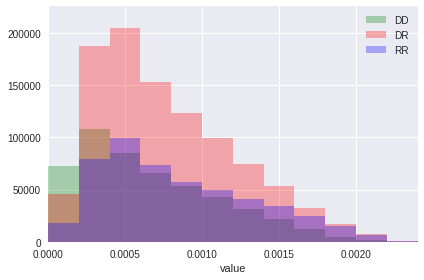

In [146]:
plot(np.array([x, y, z]).T, np.array([xrand1, yrand1, zrand1]).T, len(x), len(xrand1), 0.0002)
plt.savefig('result.png')

In [147]:
results = simple_corr(np.array([x, y, z]).T, np.array([xrand1, yrand1, zrand1]).T, len(x), len(xrand1), 0.0002)

[ 72230 108124  84621  66069  53238  43388  31462  21672  12168   4443
   1885    200] [18009 79128 99836 73537 57661 49217 41116 34096 24530 15180  6456   734] [ 45520 188020 205047 153237 123380  99089  74360  53399  32812  16940
   7456    740]


In [148]:
np.savetxt('test.txt', results, fmt='%f')